# Revenue Modeling: Wage

**Purpose:** For the tax revenue of interest, explore forecasts, testing out different combinations of 
endog and exog variables.

Once the best fit is determined, we can plug the parameters into the main "parameters.yml" file and run reproducible model fits through the command line using `kedro run`.

In [1]:
TAX_NAME = "Wage"
TAX_BASE_COLUMN = f"{TAX_NAME}Base"

## Software Setup

If changes are made to the analysis code, run the below cell to reload the changes:

In [40]:
%reload_kedro

2021-06-29 12:18:51,528 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-06-29 12:18:51,631 - root - INFO - ** Kedro project Five Year Plan Analysis
2021-06-29 12:18:51,632 - root - INFO - Defined global variable `context`, `session` and `catalog`


Imports:

In [3]:
# Base imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from phila_style.matplotlib import get_theme

# Prediction functions
from fyp_analysis.pipelines.modeling.predict import (
    get_possible_endog_variables,
    run_possible_models,
    fit_var_model,
    plot_forecast_results,
    plot_projection_comparison,
    aggregate_to_fiscal_year,
    get_avg_forecast_from_fits,
)

# The main preprocess pipeline
from fyp_analysis.pipelines.data_processing.preprocess import PreprocessPipeline
from fyp_analysis.extras.datasets import load_cbo_data, Taxes

/Users/nicholashand/miniconda3/envs/fyp/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [4]:
pd.options.display.max_columns = 999

## Parameter Setup

Set up the data catalog. We can use `DATA.load()` to load specific data instances.

In [43]:
DATA = context.catalog

Available data:

In [44]:
DATA.list()

['economic_indicators',
 'quarterly_features_raw',
 'quarterly_features_cbo_imputed',
 'features_and_bases',
 'features_and_bases_sa',
 'stationary_guide',
 'final_unscaled_features',
 'final_scaled_features',
 'scaled_feature_correlations',
 'grangers_matrix',
 'possible_endog_variables',
 'plan_details',
 'wage_fit_params',
 'sales_fit_params',
 'net_income_fit_params',
 'gross_receipts_fit_params',
 'rtt_fit_params',
 'parking_fit_params',
 'amusement_fit_params',
 'npt_fit_params',
 'parameters',
 'params:fresh_indicators',
 'params:seasonal_adjustments',
 'params:min_feature_year',
 'params:max_fit_date',
 'params:grangers_maxlag',
 'params:grangers_max_date',
 'params:plan_start_year',
 'params:cbo_forecast_date']

Load the parameter dict too:

In [45]:
PARAMS = context.params

In [46]:
PARAMS

{'fresh_indicators': False,
 'seasonal_adjustments': ['ActivityLicensesPhilly',
  'BizLicensesPhilly',
  'BuildingPermitsPhilly',
  'CPIPhillyMSA',
  'ContinuedClaimsPA',
  'WeeklyEconomicIndex',
  'DeedTransfersPhilly',
  'InitialClaimsPA',
  'UncertaintyIndex',
  'UnemploymentPhilly'],
 'min_feature_year': 1996,
 'max_fit_date': '2021-06-30',
 'grangers_maxlag': 6,
 'grangers_max_date': '2019-12-31',
 'plan_start_year': 2022,
 'cbo_forecast_date': 'latest'}

Extract specific parameters:

In [9]:
# Trim features to this start year
min_year = PARAMS["min_feature_year"]

# When is the CBO forecast from?
cbo_forecast_date = PARAMS["cbo_forecast_date"]

# First fiscal year of the plan
plan_start_year = PARAMS["plan_start_year"]

## Data Setup

Load the correlation matrix and Granger matrix:

In [10]:
C = DATA.load("scaled_feature_correlations") # correlation matrix
G = DATA.load("grangers_matrix") # Granger matrix

2021-06-29 12:10:48,201 - kedro.io.data_catalog - INFO - Loading data from `scaled_feature_correlations` (ExcelDataSet)...
2021-06-29 12:10:48,501 - kedro.io.data_catalog - INFO - Loading data from `grangers_matrix` (ExcelDataSet)...


Load taxes object responsible for loading historical tax data"

In [11]:
# Load the Plan details we are using
plan_details = DATA.load("plan_details")

# All taxes
all_taxes = Taxes(plan_details)

# This tax
this_tax = all_taxes[TAX_NAME]

2021-06-29 12:10:48,569 - kedro.io.data_catalog - INFO - Loading data from `plan_details` (PlanDetailsYAMLDataSet)...


Data associated with a tax is stored in the `.data` attribute:

In [12]:
this_tax.data.head()

,fiscal_quarter,fiscal_year,WageRevenue,rate_resident,rate_nonresident,combined_rate,WageBase
0,1,1996,2.090326e+08,0.0491,0.042753,0.037354,5.596059e+09
1,2,1996,2.107346e+08,0.0491,0.042753,0.037354,5.641624e+09
2,3,1996,2.196176e+08,0.0491,0.042753,0.037354,5.879433e+09
3,4,1996,2.118886e+08,0.0491,0.042753,0.037354,5.672519e+09
4,1,1997,2.096829e+08,0.0484,0.042082,0.036664,5.718973e+09


Load the final unscaled features:

In [13]:
unscaled_features = DATA.load("final_unscaled_features")

2021-06-29 12:10:48,822 - kedro.io.data_catalog - INFO - Loading data from `final_unscaled_features` (CSVDataSet)...


In [14]:
unscaled_features.head()

,YieldCurve,SahmRule,WagesPhillyMSA,NonfarmEmployeesPhillyMSA,NonfarmEmployeesPhilly,PersonalSavingsRate,NYCGasPrice,CarSales,RealRetailFoodServiceSales,UnemploymentRate,PPI,UnemploymentPhillyMSA,UnemploymentPhilly,CorporateProfits,RealGDP,AlcoholSales,PrimeEPOP,UncertaintyIndex,HousePriceIndexPhillyMSA,BuildingPermitsPhillyMSA,EconomicConditionsPhillyMSA,CPIPhillyMSA,InitialClaimsPA,ContinuedClaimsPA,NewManufacturingOrders,ConsumerConfidence,ManufacturingHoursWorked,PCE,RealDisposablePersonalIncome,HousingStarts,HousingSupply,GovtSocialBenefits,GDPPriceIndex,GDP,PCEPriceIndex,CPIU,10YearTreasury,3MonthTreasury,FedFundsRate,OilPriceWTI,FHFAHousePriceIndex,NonfarmEmployment,PersonalIncome,Wage&Salaries,NonresidentialInvestment,ResidentialInvestment,SP500,MedianHomeValuePhilly,AmusementBase,GrossReceiptsBase,NetIncomeBase,NPTBase,ParkingBase,RTTBase,SalesBase,WageBase
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996-01-01,0.640323,0.133333,633.494864,2488.200000,673.300000,6.666667,0.540810,15.481000,136411.666667,5.533333,126.300000,5.666667,7.615241,772.255,10817.896,1929.333333,79.866667,85.211335,105.35,1192.461261,2.993333,161.128928,24286.348514,183207.426031,48964.666667,100.506111,40.700000,5130.600000,7867.333333,1460.666667,5.966667,674.991,72.700,7868.468,72.700000,155.066667,5.910000,4.930000,5.363333,19.760000,113.72,118682.666667,6520.965,3524.466667,1003.747,344.725,637.010000,70409.666667,25221361.2,2.187766e+08,2.247482e+08,3.846310e+07,4.505538e+07,4.173158e+08,2.202701e+09,5.879433e+09
1996-04-01,0.603281,-0.023333,634.204732,2518.700000,673.933333,6.500000,0.641175,15.571667,137903.333333,5.500000,127.833333,5.466667,7.303349,784.776,10998.322,1930.666667,80.000000,76.013686,103.48,1419.918127,4.320000,162.290804,21465.862561,162774.104738,50054.333333,100.703103,41.366667,5220.533333,7939.400000,1495.666667,5.966667,680.667,72.997,8032.840,73.186667,156.400000,6.720000,5.020000,5.243333,21.696667,114.47,119471.000000,6649.846,3589.933333,1026.468,361.399,658.966667,70070.666667,36110132.0,1.794259e+09,1.843234e+09,2.124595e+08,4.785091e+07,3.134791e+08,1.707329e+09,5.672519e+09
1996-07-01,0.600000,-0.066667,634.799371,2526.300000,675.900000,6.666667,0.616141,15.364667,138152.333333,5.266667,128.166667,5.366667,7.134081,790.044,11096.976,1944.000000,80.433333,76.992084,102.40,1450.454374,2.470000,163.260178,20989.538331,156320.048762,50550.333333,101.087051,41.500000,5274.500000,8003.700000,1501.333333,5.300000,683.711,73.352,8131.408,73.498667,157.300000,6.780000,5.096667,5.306667,22.390000,115.21,120208.000000,6725.853,3647.233333,1058.965,364.315,660.543333,69872.333333,45949333.4,1.363051e+08,1.376918e+08,1.790954e+07,4.440285e+07,4.318287e+08,2.141674e+09,5.718973e+09
1996-10-01,0.550484,0.033333,645.667612,2537.900000,672.033333,6.400000,0.676531,15.401000,139499.000000,5.333333,128.433333,5.266667,7.227874,810.914,11212.205,1906.666667,80.533333,62.134891,103.38,1585.019678,3.286667,164.630069,21427.940357,153523.202698,51995.000000,101.427253,41.533333,5352.766667,8046.366667,1417.000000,5.266667,688.911,73.662,8259.771,73.999333,158.666667,6.343333,4.976667,5.280000,24.606667,115.87,120923.000000,6817.457,3704.266667,1083.597,361.806,726.793333,69969.333333,56777070.2,4.502762e+07,4.548571e+07,2.239441e+07,4.687521e+07,5.769549e+08,2.126915e+09,5.793457e+09
1997-01-01,0.522333,0.120000,651.303280,2556.266667,666.600000,6.266667,0.638361,15.589667,140960.666667,5.233333,128.500000,5.100000,7.045606,839.036,11284.587,1950.333333,80.500000,58.548450,103.72,1665.828907,3.503333,165.722588,18587.041742,149251.881603,53479.333333,101.677271,41.600000,5433.100000,8123.000000,1432.666667,4.433333,704.464,73.992,8362.655,74.326000,159.633333,6.563333,5.060000,5.276667,22.760000,116.60,121676.000000,6939.356,3776.366667,1107.299,365.359,785.590000,70345.666667,26804719.4,2.626964e+08,2.653690e+08,4.589743e+07,4.612029e+07,3.985260e+08,2.293904e+09,6.089935e+09


The final scaled features:

In [15]:
scaled_features = DATA.load("final_scaled_features")

2021-06-29 12:10:48,975 - kedro.io.data_catalog - INFO - Loading data from `final_scaled_features` (CSVDataSet)...


In [16]:
scaled_features.head()

,D.YieldCurve,D.SahmRule,D.D.Ln.WagesPhillyMSA,D.Ln.NonfarmEmployeesPhillyMSA,D.Ln.NonfarmEmployeesPhilly,D.Ln.PersonalSavingsRate,D.Ln.NYCGasPrice,D.Ln.CarSales,D.Ln.RealRetailFoodServiceSales,D.Ln.UnemploymentRate,D.Ln.PPI,D.Ln.UnemploymentPhillyMSA,D.Ln.UnemploymentPhilly,D.Ln.CorporateProfits,D.Ln.RealGDP,D.Ln.AlcoholSales,D.Ln.PrimeEPOP,D.Ln.UncertaintyIndex,D.D.Ln.HousePriceIndexPhillyMSA,D.Ln.BuildingPermitsPhillyMSA,D.EconomicConditionsPhillyMSA,D.Ln.CPIPhillyMSA,D.Ln.InitialClaimsPA,D.Ln.ContinuedClaimsPA,D.Ln.NewManufacturingOrders,D.Ln.ConsumerConfidence,D.Ln.ManufacturingHoursWorked,D.Ln.PCE,D.Ln.RealDisposablePersonalIncome,D.Ln.HousingStarts,D.Ln.HousingSupply,D.D.Ln.GovtSocialBenefits,D.Ln.GDPPriceIndex,D.Ln.GDP,D.Ln.PCEPriceIndex,D.Ln.CPIU,D.Ln.10YearTreasury,D.Ln.3MonthTreasury,D.Ln.FedFundsRate,D.Ln.OilPriceWTI,D.Ln.FHFAHousePriceIndex,D.Ln.NonfarmEmployment,D.Ln.PersonalIncome,D.Ln.Wage&Salaries,D.Ln.NonresidentialInvestment,D.Ln.ResidentialInvestment,D.Ln.SP500,D.D.Ln.MedianHomeValuePhilly,D.AmusementBase,D.GrossReceiptsBase,D.NetIncomeBase,D.NPTBase,D.Ln.ParkingBase,D.Ln.RTTBase,D.Ln.SalesBase,D.Ln.WageBase
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1997-01-01,-0.028151,0.086667,-0.008285,0.007211,-0.008118,-0.021053,-0.058075,0.012176,0.010423,-0.018928,0.000519,-0.032157,-0.025541,0.034092,0.006435,0.022644,-0.000414,-0.059453,-0.006241,0.049726,0.216667,0.006614,-0.142231,-0.028216,0.028148,0.002462,0.001604,0.014896,0.009479,0.010996,-0.172246,0.014748,0.004470,0.012379,0.004405,0.006074,0.034094,0.016606,-0.000632,-0.078013,0.006280,0.006208,0.017722,0.019277,0.021638,0.009772,0.077793,0.003977,-0.299724,0.043920,0.040621,0.074343,-0.016236,-0.369991,0.075583,0.049908
1997-04-01,-0.098583,-0.223333,-0.005558,0.005163,-0.001902,0.056863,-0.084651,-0.045918,-0.004463,-0.045611,-0.010168,-0.033226,-0.014044,0.026578,0.016483,0.021473,0.002894,0.299201,-0.006567,-0.090230,-0.070000,0.002961,0.087875,-0.030346,0.027674,0.005314,0.002401,0.006994,0.008829,0.029798,0.029632,-0.017957,0.004975,0.018502,0.002504,0.002294,0.020111,-0.002639,0.045687,-0.132946,0.008115,0.007146,0.011878,0.015572,0.019911,0.018758,0.048265,-0.001109,0.258135,0.167152,0.138132,-0.018271,0.089694,-0.014438,-0.094648,-0.047583
1997-07-01,-0.085312,0.103333,0.012688,0.008757,0.001302,-0.083819,0.083351,0.046837,0.016635,-0.027029,0.000000,-0.041385,-0.007421,0.039824,0.012431,0.011972,0.005353,-0.268573,0.012143,-0.023355,0.820000,0.004391,0.017352,-0.014462,0.072510,0.003295,-0.000800,0.019535,0.011695,-0.012499,-0.060169,-0.002059,0.002954,0.016762,0.002636,0.004988,-0.070096,0.000000,0.001809,-0.006209,0.007289,0.005812,0.015969,0.017402,0.042293,0.017771,0.120323,-0.001461,-0.070292,-0.018339,-0.021556,0.048985,-0.087370,0.410222,0.288893,0.039920
1997-10-01,-0.166663,-0.066667,0.012970,0.008464,0.009511,0.037538,-0.141757,0.019421,-0.000832,-0.041964,0.002356,-0.035846,-0.044644,-0.016932,0.008551,0.018992,-0.001644,0.130216,0.001062,0.056339,-0.476667,-0.000259,0.007374,0.016934,-0.019323,-0.000241,0.004789,0.015026,0.014623,0.049737,-0.023530,-0.000816,0.003574,0.011829,0.003132,0.005375,-0.055433,0.008550,-0.004831,0.007379,0.010752,0.007876,0.019115,0.022656,0.002339,0.017790,0.022298,-0.005815,0.170598,0.063651,0.061508,-0.060980,0.064860,0.187705,-0.223446,0.016527
1998-01-01,-0.030463,0.056667,-0.039897,0.005303,0.003315,0.160148,-0.189621,-0.049476,0.004998,-0.007168,-0.019536,-0.029632,-0.002416,-0.081392,0.009945,0.014810,-0.000411,0.227150,0.008234,0.189062,-1.206667,0.001211,0.012982,-0.016309,-0.000604,0.002640,-0.003190,0.010136,0.020831,0.017257,-0.048790,0.011728,0.001015,0.011408,0.000076,0.002060,-0.055699,-0.007230,0.002418,-0.222726,0.012372,0.006096,0.021968,0.020454,0.026118,0.023296,0.071520,-0.000397,-0.295633,-0.040535,-0.046653,0.098343,-0.008739,-0.017401,-0.021794,0.050521


Determine the name of the scaled tax base column:

In [17]:
SCALED_COLUMN = [col for col in scaled_features.columns if TAX_BASE_COLUMN in col][0]

In [18]:
SCALED_COLUMN

'D.Ln.WageBase'

Initialize the preprocesser that goes from unscaled to scaled features:

In [19]:
guide = DATA.load("stationary_guide")
preprocess = PreprocessPipeline(guide)

2021-06-29 12:10:49,481 - kedro.io.data_catalog - INFO - Loading data from `stationary_guide` (ExcelDataSet)...


In [20]:
guide.head()

,variable,ndiffs,loggable,norm,periods
0,BuildingPermitsPhilly,1,True,1,1
1,ActivityLicensesPhilly,1,True,1,1
2,BizLicensesPhilly,2,True,1,1
3,DeedTransfersPhilly,1,True,1,1
4,YieldCurve,1,False,1,1


Load the CBO data frame:

In [21]:
cbo_data = load_cbo_data(date=cbo_forecast_date)
cbo_columns = cbo_data.columns.tolist()

In [22]:
cbo_data.head()

var1,10YearTreasury,3MonthTreasury,CPIU,CorporateProfits,FHFAHousePriceIndex,FedFundsRate,GDPPriceIndex,NonfarmEmployment,NonresidentialInvestment,OilPriceWTI,PCE,PCEPriceIndex,PersonalIncome,RealGDP,ResidentialInvestment,UnemploymentRate,Wage&Salaries
Date,,,,,,,,,,,,,,,,,
2017-01-01,2.443,0.590,243.822,2064.1,236.02,0.700,107.031,145795.0,2532.5,51.77,13153.2,105.421,16633.7,17977.3,746.0,4.566,8308.8
2017-04-01,2.263,0.890,244.054,2103.0,240.23,0.950,107.368,146316.0,2555.9,48.24,13241.3,105.654,16828.4,18054.1,753.3,4.400,8399.9
2017-07-01,2.243,1.036,245.359,2136.0,243.98,1.153,107.968,146855.0,2575.2,48.16,13370.9,106.084,17036.6,18185.6,758.5,4.300,8515.3
2017-10-01,2.370,1.206,247.250,2155.0,247.93,1.203,108.637,147389.0,2634.2,55.37,13596.0,106.775,17295.6,18359.4,783.6,4.133,8661.8
2018-01-01,2.760,1.560,249.234,2206.0,252.49,1.446,109.292,148001.0,2716.2,62.89,13755.5,107.485,17548.6,18530.5,794.3,4.033,8756.4


## Forecast

In this section, we use a combination of correlations, Granger matrix, and intuition to select possible endogenous variables to include in the VAR fit. Then, we do a grid search to find the bestfit parameters based on accuracy on historical data:

### Correlations

Get top and bottom 10 correlations with our tax base:

In [23]:
C[SCALED_COLUMN].sort_values().head(n=10)

D.D.Ln.WagesPhillyMSA               -0.465148
D.Ln.UnemploymentPhillyMSA          -0.360944
D.Ln.UnemploymentRate               -0.359066
D.SahmRule                          -0.268701
D.Ln.UnemploymentPhilly             -0.266397
D.Ln.ContinuedClaimsPA              -0.258756
D.Ln.PersonalSavingsRate            -0.240030
D.D.Ln.GovtSocialBenefits           -0.145773
D.EconomicConditionsPhillyMSA       -0.140572
D.Ln.RealDisposablePersonalIncome   -0.114946
Name: D.Ln.WageBase, dtype: float64

In [24]:
C[SCALED_COLUMN].sort_values().tail(n=10)

D.Ln.Wage&Salaries                0.300727
D.Ln.RealGDP                      0.318207
D.Ln.GDP                          0.329563
D.Ln.PCE                          0.336452
D.Ln.NonfarmEmployment            0.357021
D.Ln.NonfarmEmployeesPhilly       0.365167
D.Ln.NonfarmEmployeesPhillyMSA    0.376627
D.Ln.FedFundsRate                 0.389014
D.Ln.PrimeEPOP                    0.390900
D.Ln.WageBase                     1.000000
Name: D.Ln.WageBase, dtype: float64

Load the possible endog variables:

In [25]:
possible_endog = DATA.load('possible_endog_variables')[SCALED_COLUMN]

2021-06-29 12:10:50,691 - kedro.io.data_catalog - INFO - Loading data from `possible_endog_variables` (JSONDataSet)...


In [26]:
possible_endog

['ParkingBase',
 'AmusementBase',
 'AlcoholSales',
 'RTTBase',
 'ContinuedClaimsPA',
 'InitialClaimsPA',
 'NYCGasPrice',
 'SalesBase']

### Run the grid search

This can take some time to run depending on how many variables we are searching over:

In [27]:
all_fits = run_possible_models(
    unscaled_features,
    preprocess,
    main_endog=TAX_BASE_COLUMN,
    other_endog=[
        "ContinuedClaimsPA",
        "NonfarmEmployeesPhilly",
        "NonfarmEmployeesPhillyMSA",
        "UnemploymentPhillyMSA",
        "UnemploymentPhilly",
        "WagesPhillyMSA",
    ],
    orders=[2, 3, 4, 5, 6, 7, 8],
    grangers=G,
    max_fit_date=["2019-12-31", "2021-06-30"],
    cbo_columns=cbo_columns,
    alpha=0.05,
    max_exog=4,
    max_other_endog=1,
    model_quarters=[True, False],
)

Split fits that do and do not have at least one CBO variable as exogenous variable:

In [28]:
fits_with_exog = list(filter(lambda d: len(d["exog_cols"]) > 0, all_fits))
fits_no_exog = list(filter(lambda d: len(d["exog_cols"]) == 0, all_fits))

Compare the historical accuracy of the top fits with and without exog variables:

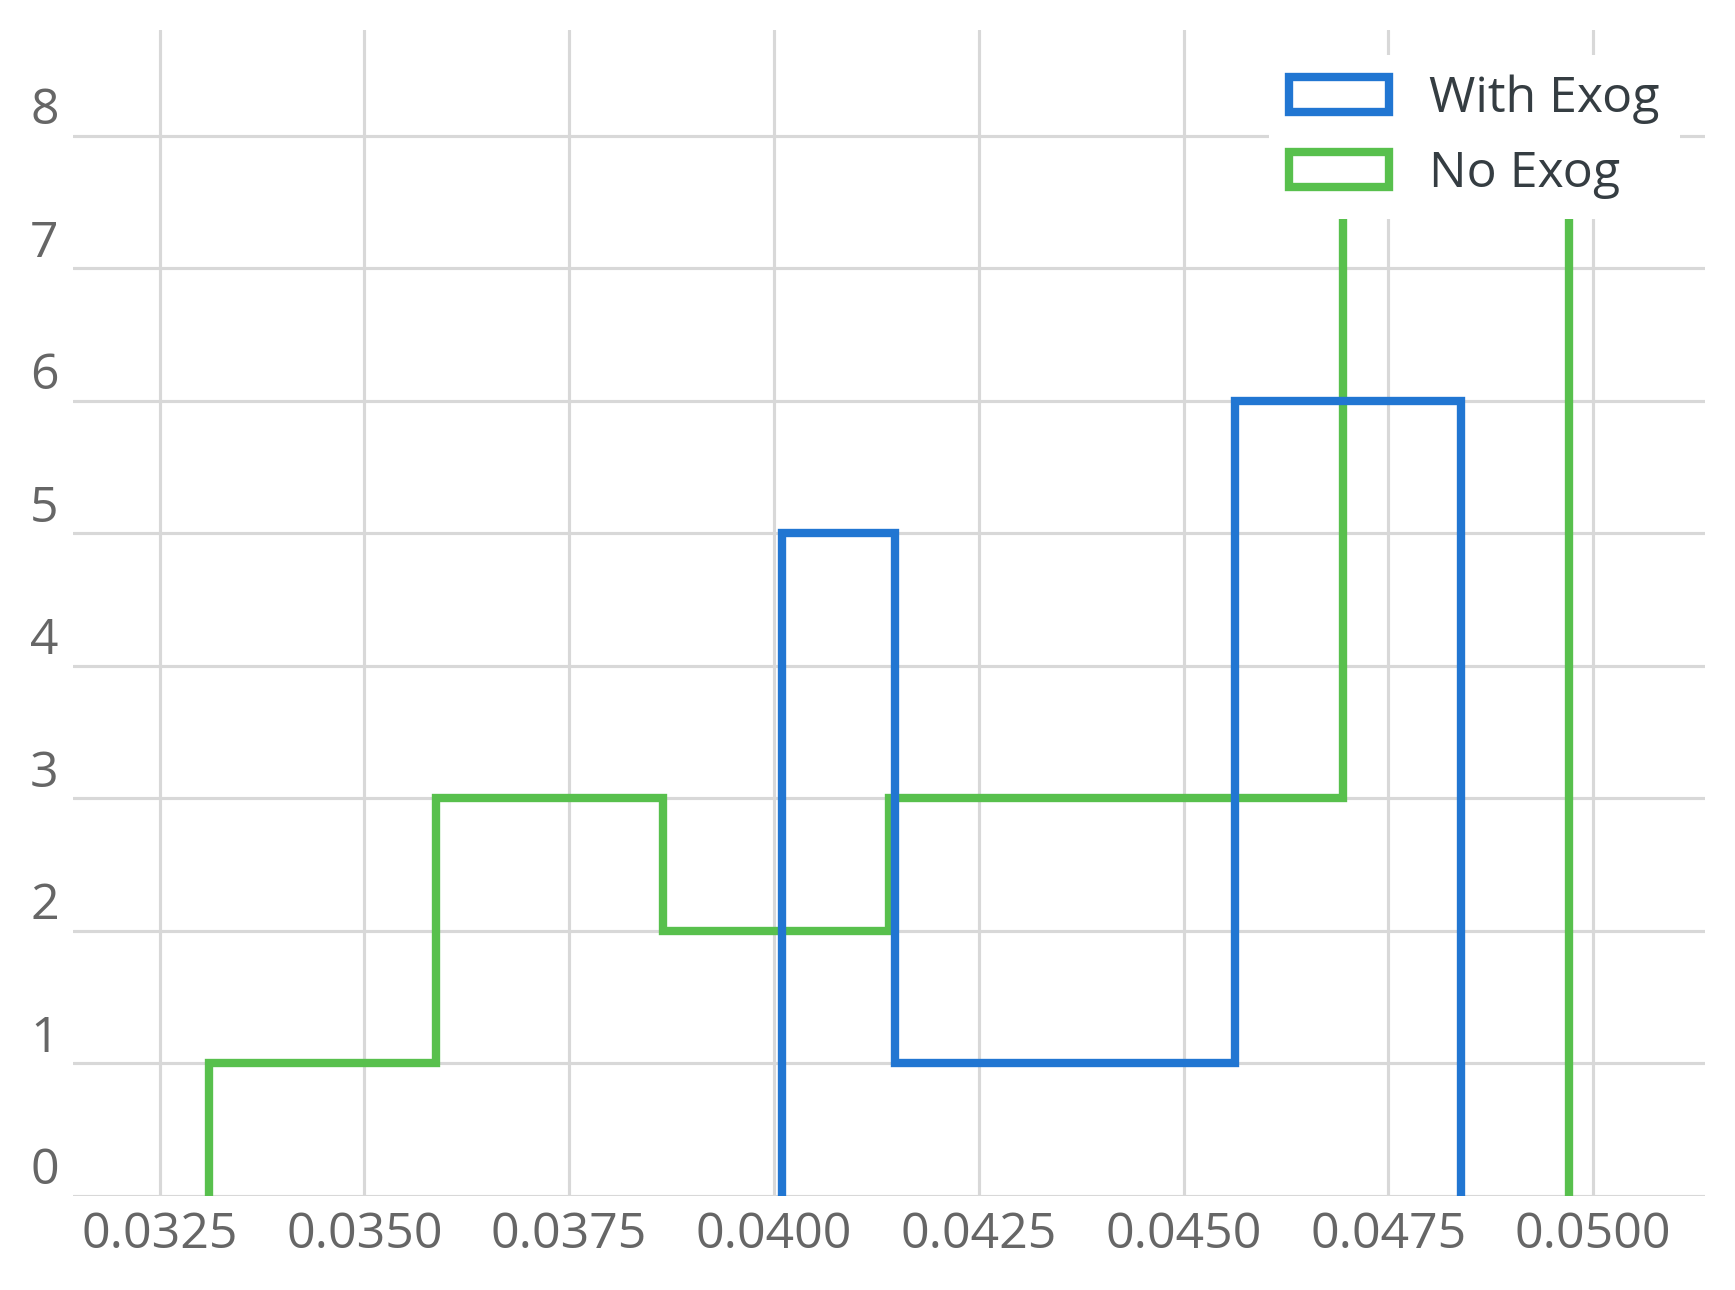

In [29]:
with plt.style.context(get_theme()):

    fig, ax = plt.subplots()

    ax.hist(
        [d["target_mape"] for d in fits_with_exog[:20]],
        bins="auto",
        histtype="step",
        label="With Exog",
        zorder=10,
        lw=2,
    )
    ax.hist(
        [d["target_mape"] for d in fits_no_exog[:20]],
        bins="auto",
        histtype="step",
        label="No Exog",
        lw=2,
    )
    ax.legend()

**Takeaway**: Without exog appears to be more accurate

### Run the VAR with the best-fit params

In [30]:
best_params = fits_no_exog[0]
best_params

{'mape_splits': [WageBase                 0.037025
  UnemploymentPhillyMSA    0.163476
  dtype: float64,
  WageBase                 0.034013
  UnemploymentPhillyMSA    0.284972
  dtype: float64,
  WageBase                 0.028281
  UnemploymentPhillyMSA    0.341008
  dtype: float64],
 'mape': WageBase                 0.033106
 UnemploymentPhillyMSA    0.263152
 dtype: float64,
 'order': 2,
 'endog_cols': ['WageBase', 'UnemploymentPhillyMSA'],
 'exog_cols': [],
 'model_quarters': True,
 'max_fit_date': '2019-12-31',
 'target_mape': 0.03310618145900017}

In [31]:
result, forecast = fit_var_model(
    unscaled_features,
    preprocess,
    plan_start_year=plan_start_year,
    max_fit_date=best_params["max_fit_date"],
    cbo_data=cbo_data,
    endog_cols=best_params["endog_cols"],
    order=best_params["order"],
    exog_cols=best_params["exog_cols"],
    model_quarters=best_params["model_quarters"],
)
print(result.aic)

-13.450246827780893


In [32]:
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, Jun, 2021
Time:                     12:16:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.0058
Nobs:                     90.0000    HQIC:                  -13.2710
Log likelihood:           365.852    FPE:                1.44225e-06
AIC:                     -13.4502    Det(Omega_mle):     1.21639e-06
--------------------------------------------------------------------
Results for equation D.Ln.WageBase
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                 0.074838         0.009985            7.495           0.000
month_4                              -0.041491         0.016380           -2.533     

2021-06-29 12:16:21.585 | INFO     | fyp_analysis.pipelines.modeling.predict.viz:plot_forecast_results:62 - Year-over-Year Change
2021-06-29 12:16:21.587 | INFO     | fyp_analysis.pipelines.modeling.predict.viz:plot_forecast_results:63 - 2020    0.012463
2021   -0.064079
2022    0.054521
2023    0.045609
2024    0.041247
2025    0.040173
2026    0.040015
Name: WageBase, dtype: float64


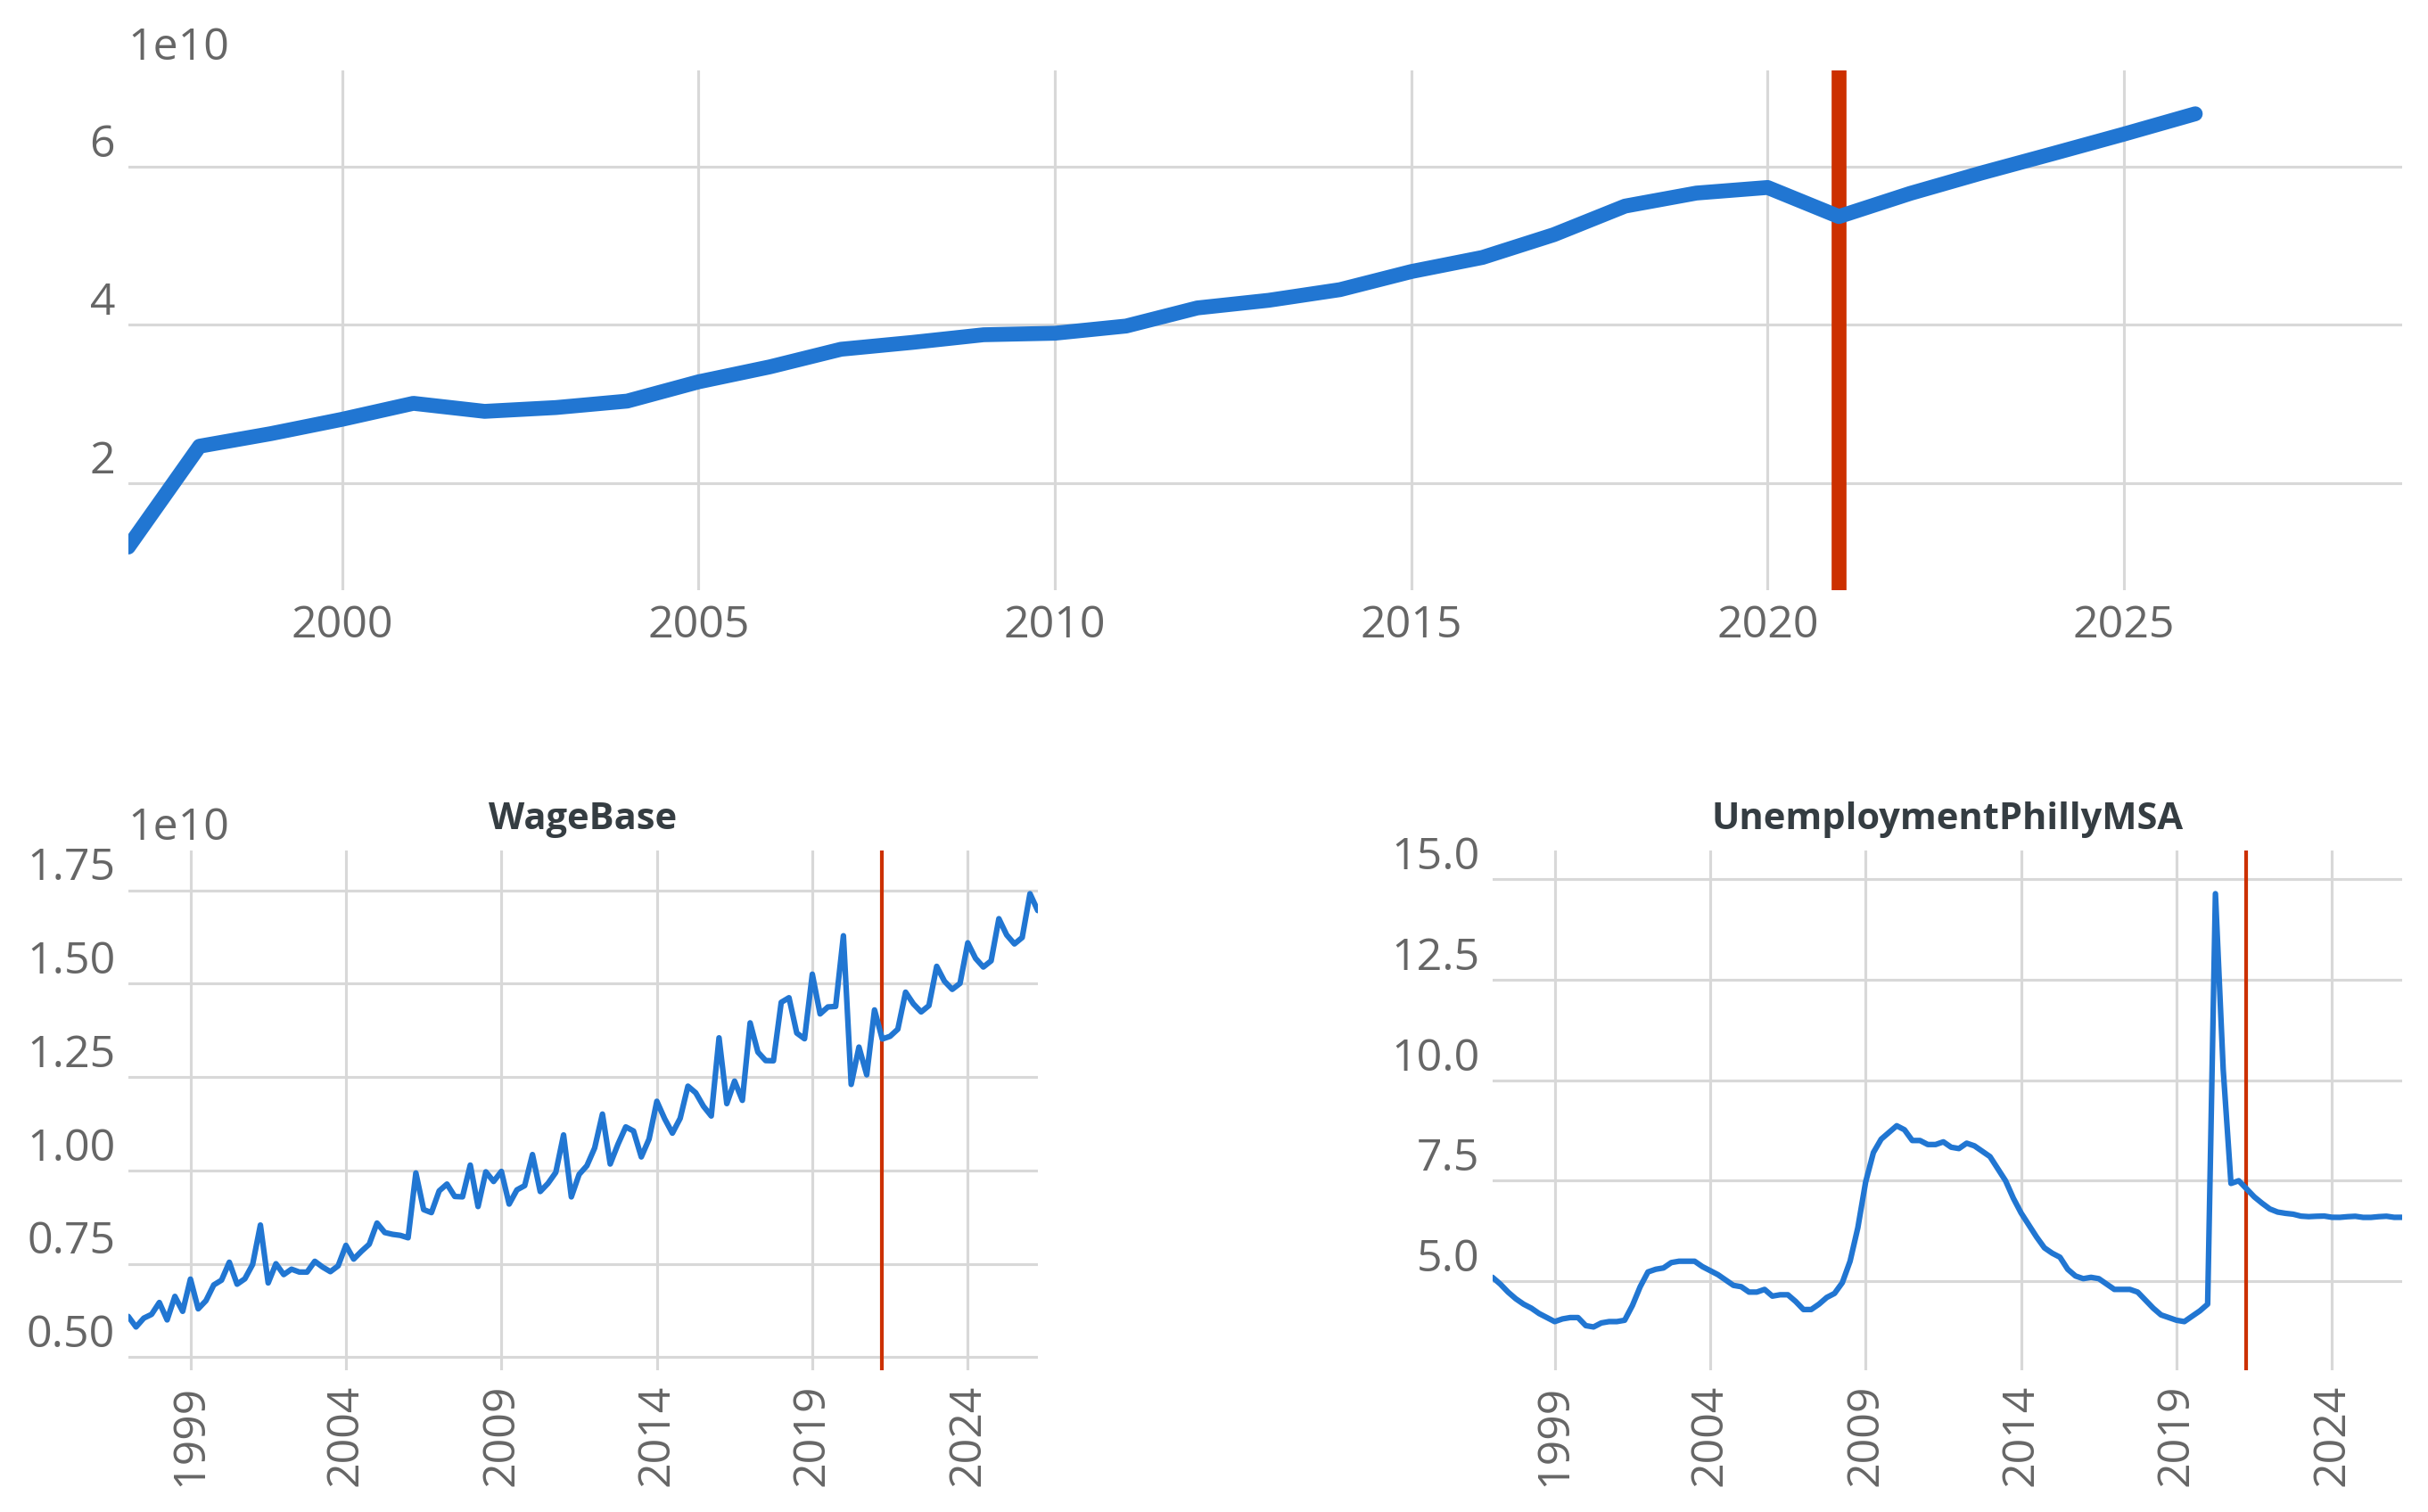

In [33]:
fig = plot_forecast_results(forecast, TAX_BASE_COLUMN);

### Compare to Budget Office Projections

Aggregate to fiscal year:

In [34]:
F = aggregate_to_fiscal_year(forecast[TAX_BASE_COLUMN])

Plot:

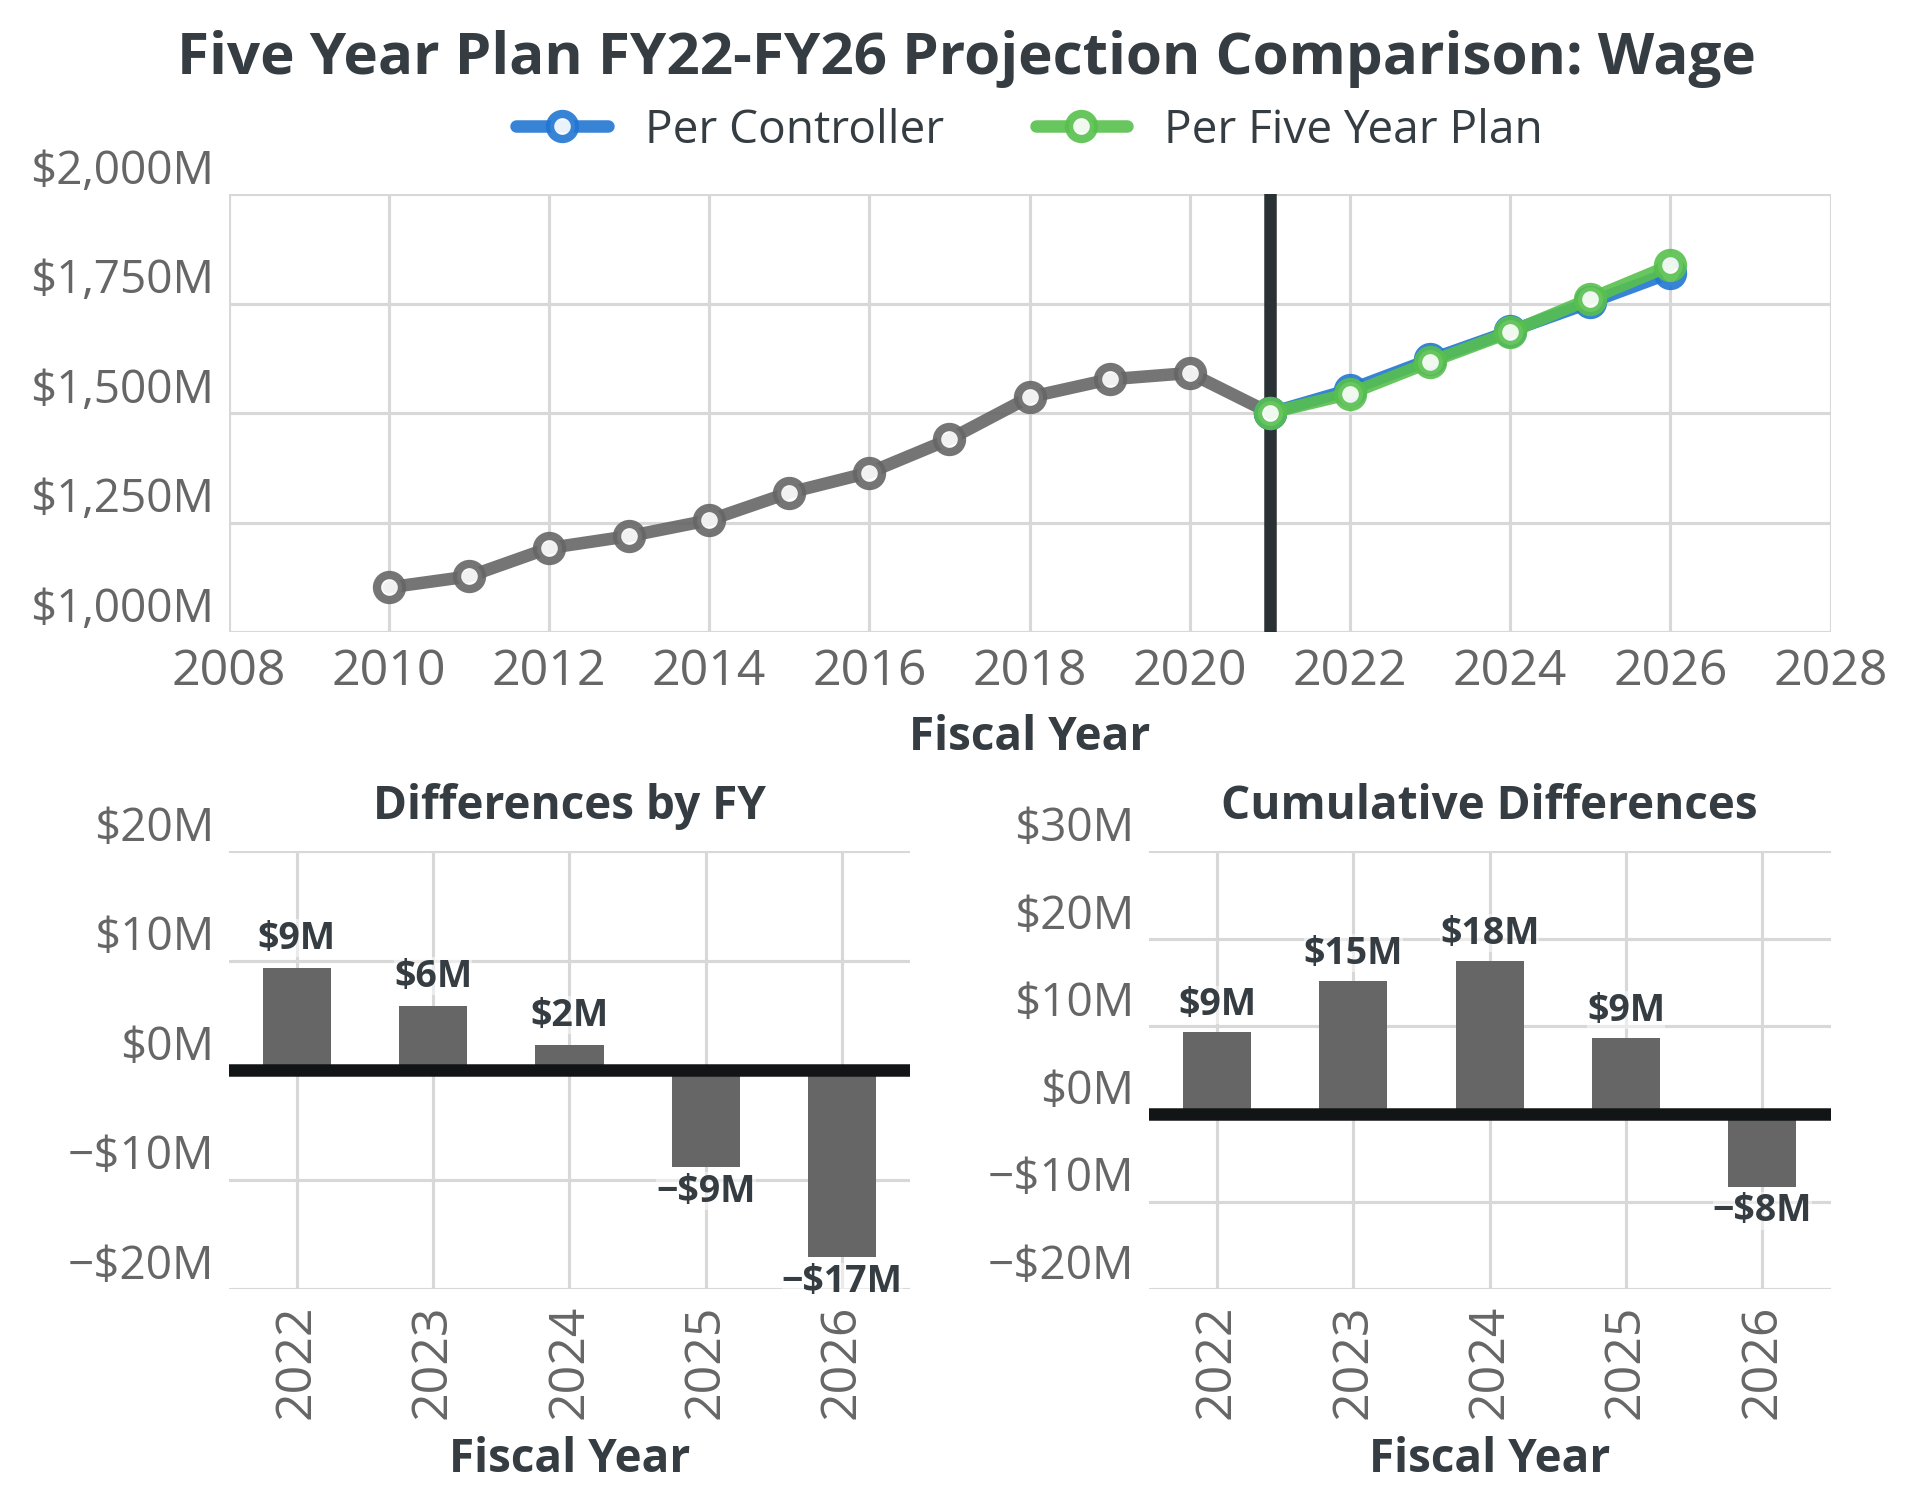

In [36]:
plot_projection_comparison(this_tax, F.squeeze());

### Save Best-fit Parameters

In [47]:
DATA.save("wage_fit_params", best_params)

2021-06-29 12:19:16,017 - kedro.io.data_catalog - INFO - Saving data to `wage_fit_params` (PickleDataSet)...
